In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#データセットのダウンロード
from urllib import request
# trainデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/train.pickle'
request.urlretrieve(url, 'train.pickle')

# testデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/test.pickle'
request.urlretrieve(url, 'test.pickle')

# ラベルデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/label.pickle'
request.urlretrieve(url, 'label.pickle')

('label.pickle', <http.client.HTTPMessage at 0x163b321c0f0>)

In [3]:
import pickle

In [4]:
#pickle形式を読み込む関数
def unpickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

In [5]:
#データの読み込み
train = unpickle('train.pickle')
test = unpickle('test.pickle')
label = unpickle('label.pickle')

In [6]:
print(type(train))
print(type(test))
print(type(label))

<class 'dict'>
<class 'dict'>
<class 'list'>


In [7]:
label

['clock', 'cup', 'bicycle', 'television', 'chair']

In [8]:
train

{'data': array([[[[241., 242., 237., ...,  27.,  16.,   9.],
          [238., 239., 231., ...,  36.,  44.,  67.],
          [237., 233., 223., ...,  93.,  53., 111.],
          ...,
          [189., 192., 192., ..., 200., 210., 208.],
          [191., 195., 196., ..., 216., 226., 222.],
          [199., 204., 205., ..., 244., 246., 245.]],
 
         [[241., 242., 238., ...,  28.,  16.,   9.],
          [238., 239., 232., ...,  39.,  47.,  72.],
          [237., 234., 226., ..., 103.,  62., 120.],
          ...,
          [193., 196., 196., ..., 205., 217., 215.],
          [195., 199., 199., ..., 219., 229., 227.],
          [202., 207., 208., ..., 244., 246., 246.]],
 
         [[248., 249., 245., ...,  32.,  20.,  12.],
          [246., 248., 243., ...,  35.,  43.,  67.],
          [245., 245., 240., ...,  89.,  48., 110.],
          ...,
          [204., 208., 207., ..., 209., 225., 222.],
          [207., 211., 212., ..., 216., 233., 231.],
          [214., 219., 220., ..., 243., 

In [10]:
#データを変数に格納
data_train = train['data']
label_train = train['label']
data_test = test['data']
label_test = test['label']

In [11]:
len(data_train)

2500

In [12]:
#画像サイズを確認
print(data_train.shape)
print(data_test.shape)

(2500, 3, 32, 32)
(500, 3, 32, 32)


In [13]:
#正規化
data_train /= 255
data_test /= 255

In [16]:
#画像出力
#[注意]imshow()が読み込めるように要素を変換

def show_test_sample_info(index):
    #(channel, height, width) => (height, width, channel)
    img = data_test[index].transpose(1, 2, 0)
    
    plt.imshow(img)
    plt.show()
    
    print('class:' + label[label_test[index]])
    print('label:' + str(label_test[index]) )

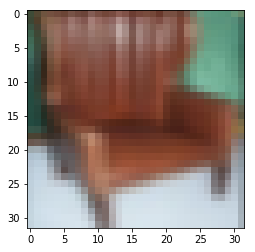

class:chair
label:4


In [17]:
show_test_sample_info(402)

In [18]:
#ここからネットワークの構築に入る

In [19]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

In [20]:
#CNNの定義
class CNN(chainer.Chain):
    #層の作成
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels = 3, out_channels = 64, ksize = 4, stride = 1, pad = 2) #padは意外にも大事
            self.conv2 = L.Convolution2D(in_channels = 64, out_channels = 128, ksize = 4, stride = 1, pad = 2)
            self.conv3 = L.Convolution2D(in_channels = None, out_channels = 128, ksize = 4, stride = 1, pad = 2)
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 5) #out_channelsは分類するクラス数と同じ５に設定
            
    def __call__(self, x):
        h = F.relu(F.max_pooling_2d(self.conv1(x), ksize = 2)) #conv1の畳み込みのあとにMaxpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize = 2)) #conv2の畳み込みのあとにMaxpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize = 2)) #conv3の畳み込みのあとにMaxpoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [21]:
#ここから学習に入る

In [23]:
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

In [24]:
#分類器インスタンスの生成
model = L.Classifier(CNN())

#optimizerの生成
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)

#ミニバッチの設定
batch_size = 100

n_epoch = 100

In [27]:
#trainerの定義
train = tuple_dataset.TupleDataset(data_train, label_train)
train_iter = iterators.SerialIterator(train, batch_size = batch_size, shuffle = True)
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out = 'result')

In [28]:
#Extensionsを利用してtrainerの機能（主に出力表示）をつける
#まず、評価
test = tuple_dataset.TupleDataset(data_test, label_test)
test_iter = iterators.SerialIterator(test, batch_size = batch_size, shuffle = 'False', repeat = False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch',file_name='loss.png'))

In [29]:
#学習を実行
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.2556         1.58139     0.294                     1.54351               
2           0.3008         1.54225     0.392                     1.50778               
3           0.3372         1.50799     0.302                     1.51871               
4           0.35           1.4854      0.388                     1.4392                
     total [##................................................]  4.00%
this epoch [..................................................]  0.00%
       100 iter, 4 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
5           0.394          1.44297     0.37                      1.44928               
6           0.3956         1.43064     0.434                     1.42445               
7           0.4172         1.40476     0.452                     1.36696               
8           0.4168         1.39219     0.476                 

57          0.8024         0.558203    0.614                     1.01391               
58          0.8188         0.533347    0.758                     0.704448              
59          0.8156         0.537915    0.694                     0.824492              
60          0.8244         0.537377    0.686                     0.84196               
     total [##############################....................] 60.00%
this epoch [..................................................]  0.00%
      1500 iter, 60 epoch / 100 epochs
   0.44414 iters/sec. Estimated time to finish: 0:37:31.517351.
61          0.8308         0.499456    0.712                     0.779405              
62          0.8384         0.495277    0.732                     0.764396              
63          0.8404         0.473809    0.74                      0.714754              
64          0.8328         0.486254    0.704                     0.843256              
     total [################################.......

In [30]:
# モデルを利用して予測をする関数を定義
def predict(model, X):
    if len(X.shape) == 3:  # データ数が1の場合は、バッチサイズ分の次元を追加
        pred = model.predictor(X[None, ...]).data.argmax()
    else:  # データ数が2以上の場合はそのまま
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

In [31]:
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(label_test, predict(model, data_test)))
print('recall: %.3f' % metrics.recall_score(label_test, predict(model, data_test), average = 'macro'))
print('precision:  %.3f' % metrics.precision_score(label_test, predict(model, data_test), average = 'macro'))
print('f1_score: %.3f' % metrics.f1_score(label_test, predict(model, data_test), average = 'macro'))

accuracy: 0.760
recall: 0.760
precision:  0.764
f1_score: 0.757


In [32]:
# PlotReportによるグラフを出力する関数
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

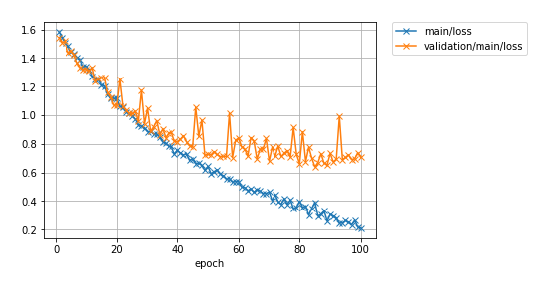

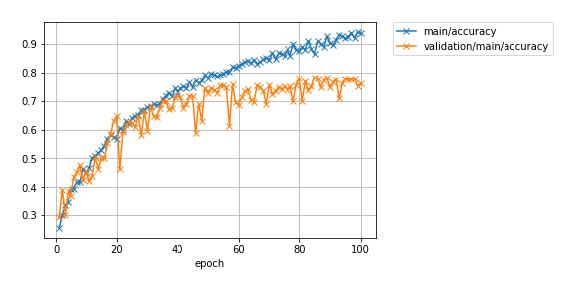

In [34]:
show_graph('result/loss.png')
show_graph('result/accuracy.png')

In [35]:
#上の評価を見ると、40epochで精度70%で頭打ちになっている
#運用では40-50epochぐらいのモデルを使ったほうがいい

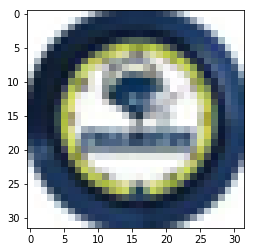

class:clock
label:0
predict: 0
OK


In [37]:
#実際の写真を使ってモデルの精度を見る

index = 10
show_test_sample_info(index)

pred = predict(model, data_test[index])
print('predict: {}'.format(pred))

if (pred == label_test[index]):
    print('OK')
else:
    print('NG')

In [38]:
#予測が外れたデータの分析

errors = []
for i in range(len(label_test)):
    pred_ = predict(model, data_test[i])
    if pred_ != label_test[i]:
        errors.append((i, label[label_test[i]], label[pred_]))

In [39]:
len(errors)

120

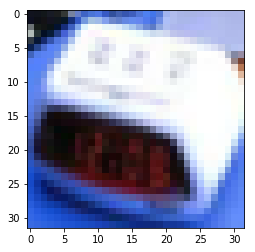

class:clock
label:0
clock
television


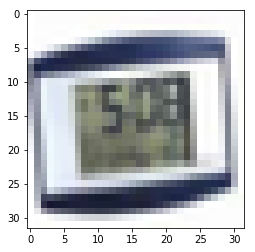

class:clock
label:0
clock
television


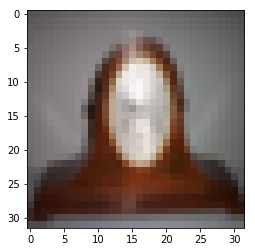

class:clock
label:0
clock
television


In [40]:
for error_index, corr_label, pred_label in errors[:3]:
    show_test_sample_info(error_index)
    print(corr_label)
    print(pred_label)

In [41]:
#とりあえず、モデルの保存

In [42]:
serializers.save_npz('CNN.model', model)
print('OK')

OK


In [1]:
model_reloaded = L.Classifier(CNN()) 
serializers.load_npz('CNN.model', model_reloaded)
print('OK')

NameError: name 'L' is not defined

In [2]:
#ここから自分の画像を識別してもらう

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# testデータのサンプルについて情報を確認する関数
# (testデータのindex)
def show_test_sample_info(index):
    # (channel, height, width)を(height, width, channel)に変換
    img = X_test[index].transpose(1,2,0)
    
    # 画像を出力
    plt.imshow(img)
    plt.show()
    
    # 正解ラベルを出力
    print('class: ' + label[y_test[index]])
    print('label: ' + str(y_test[index]))

In [5]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

In [6]:
# CNNの定義
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 5) # out_channelはクラス数と同じ5に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [8]:
#必要なライブラリを読み込み
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

In [9]:
model_reloaded = L.Classifier(CNN()) 
serializers.load_npz('CNN.model', model_reloaded)
print('OK')

OK


In [10]:
def predict(model, x):
    if len(x.shape) == 3:
        pred = model.predictor(x[None, ...]).data.argmax()
    else:
        pred = model.predictor(x).data.argmax(axis=1)
    return pred